In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting  import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from acquire import *

## Required Functions 

In [2]:
def time_split(df, train_size = .5, validate_size = .3):
    '''Splits time series data based on percentages and returns train, validate, test THE
    DATAFRAME MUST BE CHRONOLOGICALLY SORTED!'''
    t_size = int(len(df) * train_size)
    v_size = int(len(df) * validate_size)
    end = t_size + v_size
    return df[0:t_size], df[t_size:end], df[end:len(df)+1]

def plot_samples(target_var):
    '''
   plot each attribute 
   '''
    plt.figure(figsize = (12,4))
    sns.lineplot(data=train[target_var], label='train')
    sns.lineplot(data=validate[target_var], label='validate')
    sns.lineplot(data=test[target_var], label='test')
    plt.title(target_var.title())
    plt.legend()
    
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values and the predicted values
    and compute the mean_squared_error and then take the sqrt returning a rounded rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    sns.lineplot(data=yhat_df[target_var], label='RMSE')
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'--RMSE: {rmse:.0f}')
    plt.show()

def append_eval_df(model_type, target_var):
    '''
    this function will take in the model type as a string, target variable
    as a string, and run the evaluate function to compute rmse, 
    and append to the dataframe a row with the model type, 
    target variable and rmse. 
    '''
    rmse = evaluate(target_var)
    d= {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d= pd.DataFrame(d)
    return eval_df.append(d, ignore_index= True)

def previous_plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    rmse = evaluate(target_var)
    print(target_var, f'--RMSE: {rmse:.0f}')
    return rmse

### Going to do time-series analysis on Washington

In [3]:
df = pd.read_csv('GlobalLandTemperaturesByCity.csv' )
df = df[df.City == 'Washington']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 8161899 to 8165137
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             3239 non-null   object 
 1   AverageTemperature             3119 non-null   float64
 2   AverageTemperatureUncertainty  3119 non-null   float64
 3   City                           3239 non-null   object 
 4   Country                        3239 non-null   object 
 5   Latitude                       3239 non-null   object 
 6   Longitude                      3239 non-null   object 
dtypes: float64(2), object(5)
memory usage: 202.4+ KB


In [4]:
# Fix column names to lower_case
new_names = {col: col.lower() for col in df.columns}
df.rename(columns=new_names, inplace=True)
df.head()

,dt,averagetemperature,averagetemperatureuncertainty,city,country,latitude,longitude
8161899,1743-11-01,5.339,1.828,Washington,United States,39.38N,76.99W
8161900,1743-12-01,NaN,NaN,Washington,United States,39.38N,76.99W
8161901,1744-01-01,NaN,NaN,Washington,United States,39.38N,76.99W
8161902,1744-02-01,NaN,NaN,Washington,United States,39.38N,76.99W
8161903,1744-03-01,NaN,NaN,Washington,United States,39.38N,76.99W


In [5]:
# The dates range from 1743 - 2013 and look to be in increments of 1 month
df.dt.min(), df.dt.max()

# Convert to datetime format
df.dt = pd.to_datetime(df.dt)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 8161899 to 8165137
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             3239 non-null   datetime64[ns]
 1   averagetemperature             3119 non-null   float64       
 2   averagetemperatureuncertainty  3119 non-null   float64       
 3   city                           3239 non-null   object        
 4   country                        3239 non-null   object        
 5   latitude                       3239 non-null   object        
 6   longitude                      3239 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 202.4+ KB


### Fill null values

In [6]:
df = df.rename(columns={'dt': 'date'})
df = df.set_index('date')[['averagetemperature', 'averagetemperatureuncertainty']].sort_index()
df['month'] = df.index.month_name()

In [7]:
# Since each month can have significantly different temperatures, we need to fillna by month
months = [val for val in df.month.unique()]

new_df = pd.DataFrame()

for month in months:
    _ = df[df.month == month]
    _.averagetemperature = _.averagetemperature.fillna(_.averagetemperature.rolling(7, min_periods=0).mean())
    _.averagetemperatureuncertainty = _.averagetemperatureuncertainty.fillna(_.averagetemperatureuncertainty.rolling(7, min_periods=0).mean())
    new_df = new_df.append(_)

df = new_df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3239 entries, 1743-11-01 to 2013-09-01
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   averagetemperature             3228 non-null   float64
 1   averagetemperatureuncertainty  3228 non-null   float64
 2   month                          3239 non-null   object 
dtypes: float64(2), object(1)
memory usage: 101.2+ KB


In [8]:
# It seems there are still a few null values, we can just drop these observations
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3228 entries, 1743-11-01 to 2013-09-01
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   averagetemperature             3228 non-null   float64
 1   averagetemperatureuncertainty  3228 non-null   float64
 2   month                          3228 non-null   object 
dtypes: float64(2), object(1)
memory usage: 100.9+ KB


### Rename columns for better readability

In [9]:
df = df.rename(columns={'averagetemperature': 'avg', 'averagetemperatureuncertainty': 'avg_unc'})

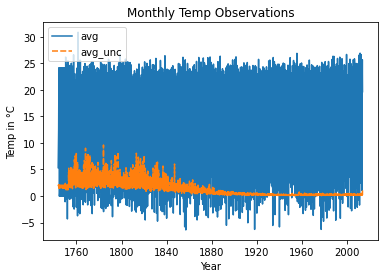

In [10]:
sns.lineplot(data=df).set(title='Monthly Temp Observations')
plt.ylabel('Temp in °C')
plt.xlabel('Year')
plt.show()

### Change the increments to yearly and see how the data looks


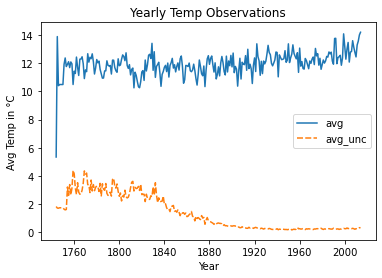

In [11]:
yearly = df.resample('Y').mean()
sns.lineplot(data = yearly).set(title='Yearly Temp Observations')
plt.ylabel('Avg Temp in °C')
plt.xlabel('Year')
plt.show()

# Drop monthly column
df = df.drop(columns=['month'])

### Change increments to every 5 years to get a bit more overall data

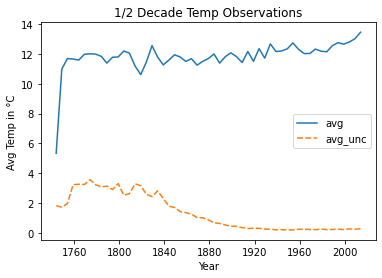

In [12]:
year_5 = df.resample('5Y').mean()
sns.lineplot(data = year_5).set(title='1/2 Decade Temp Observations')
plt.ylabel('Avg Temp in °C')
plt.xlabel('Year')
plt.show()

### Time to split the data into train, validate, test 

In [13]:
train, validate, test = time_split(df, train_size=.6, validate_size=.2)
train.shape, validate.shape, test.shape

((1936, 2), (645, 2), (647, 2))

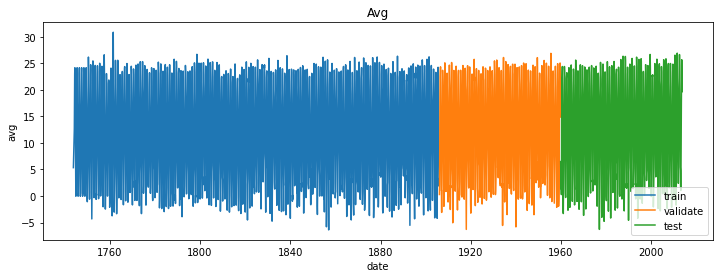

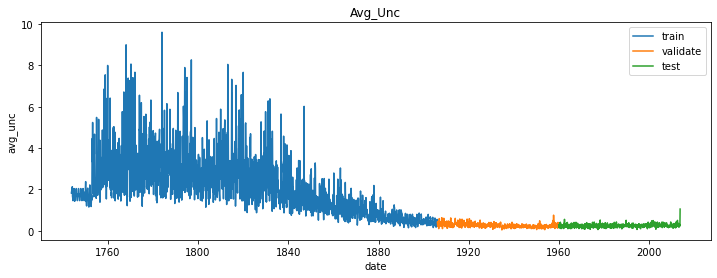

In [14]:
for col in train.columns:
    plot_samples(col)
    plt.show()


<h2><center>Forecast</center></h2>

### Last Observed Value

In [15]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

avg_temp = train.avg[-1]
avg_unc = train.avg_unc[-1]
yhat_df = pd.DataFrame({'avg': [avg_temp], 'avg_unc': avg_unc},
                       index=validate.index)
yhat_df.head()

,avg,avg_unc
date,,
1906-02-01,3.254,0.512
1906-03-01,3.254,0.512
1906-04-01,3.254,0.512
1906-05-01,3.254,0.512
1906-06-01,3.254,0.512


avg --RMSE: 13


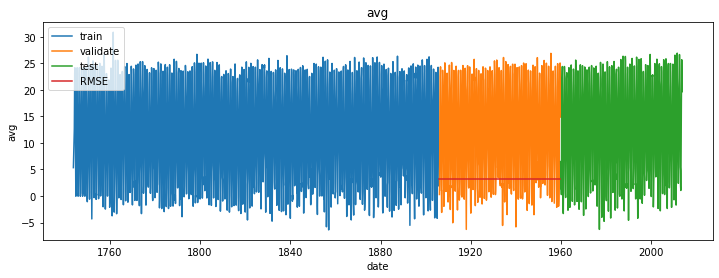

avg_unc --RMSE: 0


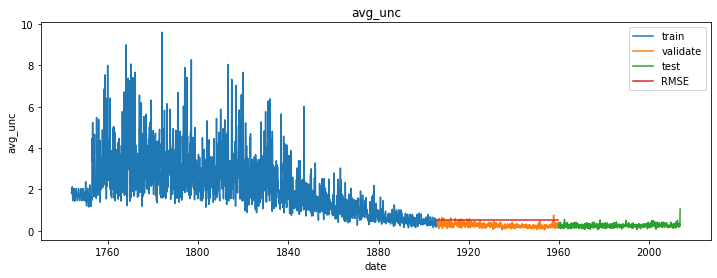

In [16]:
for column in train.columns:
    plot_and_eval(column)

In [17]:
for column in train.columns:
    eval_df = append_eval_df(model_type='last_observed_value',
                            target_var= column)
eval_df.head()

,model_type,target_var,rmse
0,last_observed_value,avg,13.0
1,last_observed_value,avg_unc,0.0


### Simple Average

> - Utilize historical value averages to make predictions about the future values.

In [18]:
avg = round(train.avg.mean(), 0)
avg_unc = round(train.avg_unc.mean(), 0)
yhat_df = pd.DataFrame({'avg': [avg], 'avg_unc': avg_unc},
                       index=validate.index)
yhat_df.head()

,avg,avg_unc
date,,
1906-02-01,12.0,2.0
1906-03-01,12.0,2.0
1906-04-01,12.0,2.0
1906-05-01,12.0,2.0
1906-06-01,12.0,2.0


avg_unc --RMSE: 2


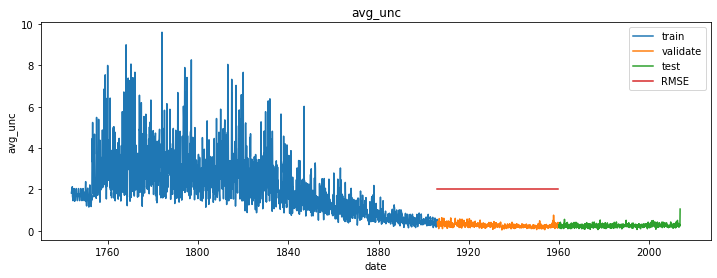

avg_unc --RMSE: 2


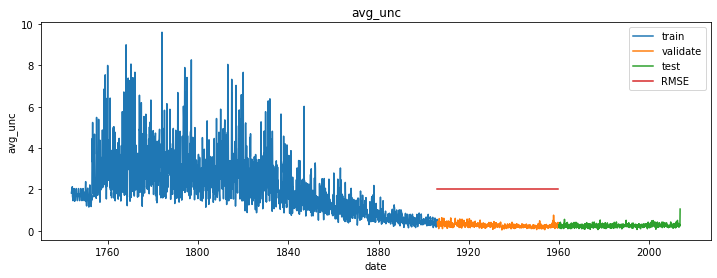

,model_type,target_var,rmse
0,last_observed_value,avg,13.0
1,last_observed_value,avg_unc,0.0
2,simple_average,avg,9.0
3,simple_average,avg_unc,2.0


In [19]:
for columns in train.columns:
    plot_and_eval(column)
    
for column in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average',
                             target_var = column)
eval_df.head()

### Moving/Rolling Average
> - We will using a rolling monthly average (which will be tested for increasing period) up to a 48 months.

avg --RMSE: 9


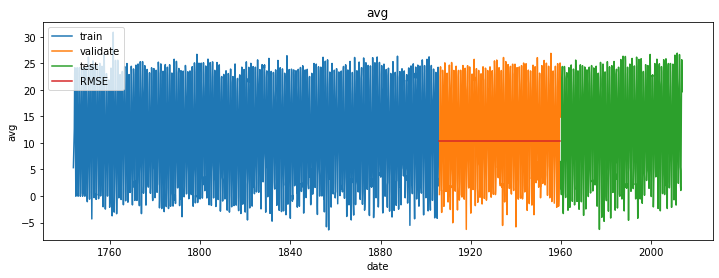

avg_unc --RMSE: 0


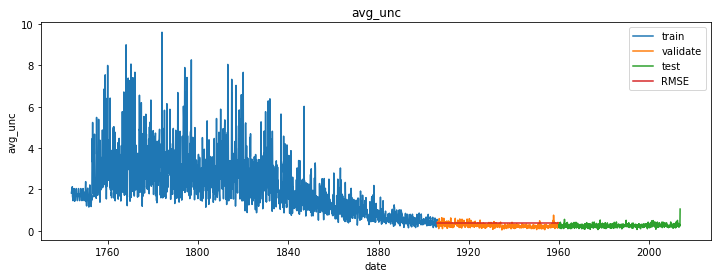

,model_type,target_var,rmse
0,last_observed_value,avg,13.0
1,last_observed_value,avg_unc,0.0
2,simple_average,avg,9.0
3,simple_average,avg_unc,2.0
4,moving_average_17_months,avg,9.0
5,moving_average_17_months,avg_unc,0.0


In [20]:
period = 17
avg = train.avg.rolling(period).mean().iloc[-1]
avg_unc = train.avg_unc.rolling(period).mean().iloc[-1]
yhat_df = pd.DataFrame({'avg': [avg], 'avg_unc': avg_unc},
               index=validate.index)
for column in train.columns:
    plot_and_eval(column)
for column in train.columns:
    eval_df = append_eval_df(model_type = f'moving_average_{period}_months',
                     target_var = column)
eval_df

### Holt's Linear Trend

avg


<Figure size 864x288 with 0 Axes>

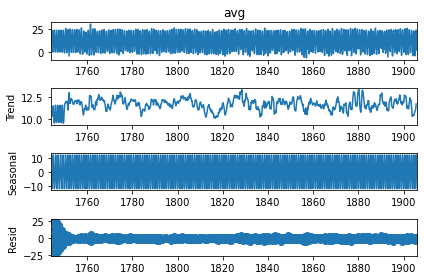

avg_unc


<Figure size 864x288 with 0 Axes>

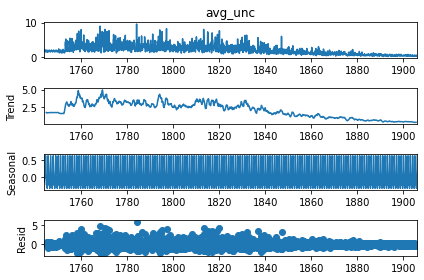

In [21]:
for column in train.columns:
    print(column, end='\n')
    plt.figure(figsize = (12,4))
    _ = sm.tsa.seasonal_decompose(train[column], period=12).plot()
    plt.show()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


avg --RMSE: 4


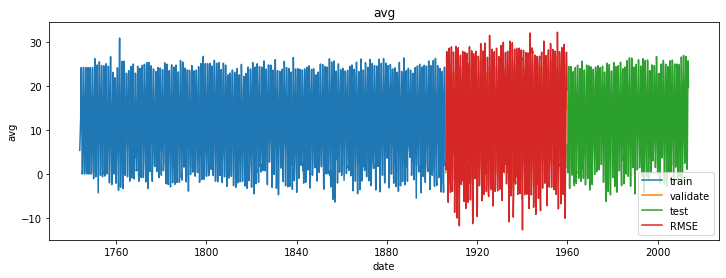

avg_unc --RMSE: 0


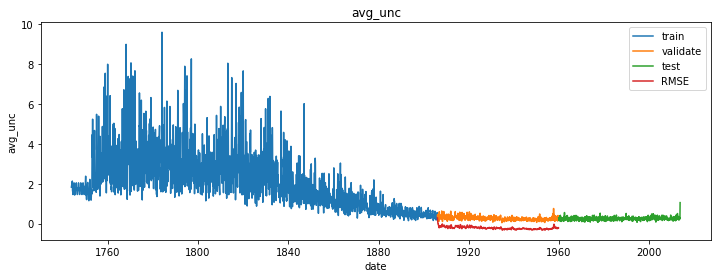

,model_type,target_var,rmse
0,last_observed_value,avg,13.0
1,last_observed_value,avg_unc,0.0
2,simple_average,avg,9.0
3,simple_average,avg_unc,2.0
4,moving_average_17_months,avg,9.0
5,moving_average_17_months,avg_unc,0.0
6,Holts,avg,4.0
7,Holts,avg_unc,0.0


In [22]:
for column in train.columns:
    # Make model
    model = Holt(validate[column], exponential=False)
    # Fit model
    if column == 'avg':
        s, l = .66, .98
    else:
        s, l = .0, .26
    model = model.fit(smoothing_level=l,
                     smoothing_slope=s,
                     optimized=False)
    yhat = model.predict(start=validate.index[0],
                        end=validate.index[-1])
    yhat_df[column] = round(yhat, 2)

for column in train.columns:
    plot_and_eval(column)
    eval_df = append_eval_df(model_type='Holts',
                            target_var=column)
eval_df

### Previous Cycle
> - Utilize a previous cycle which will be x increments of months

avg --RMSE: 5


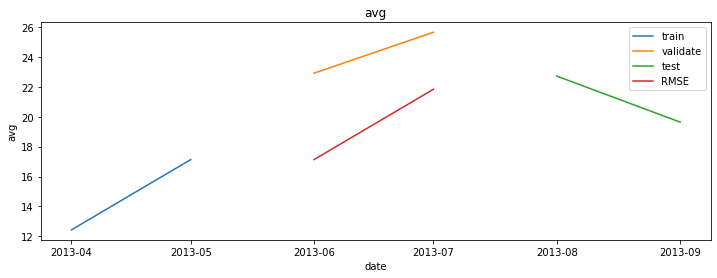

avg_unc --RMSE: 0


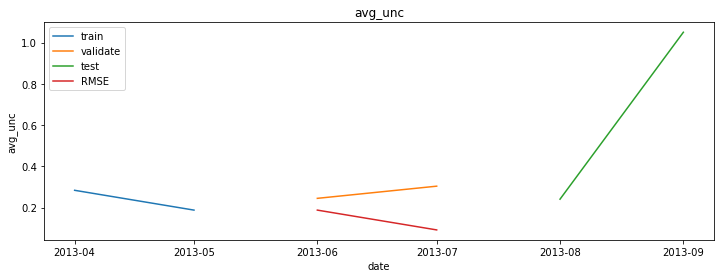

avg --RMSE: 14


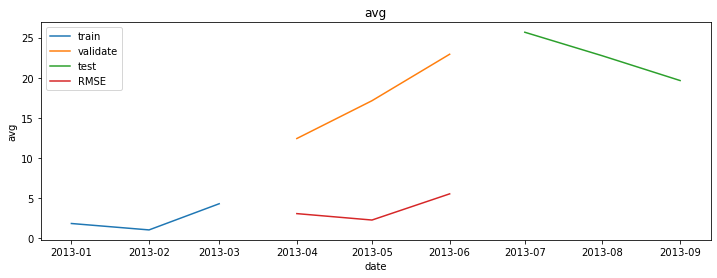

avg_unc --RMSE: 0


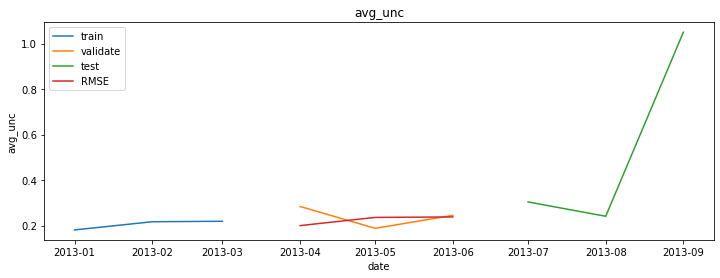

avg --RMSE: 12


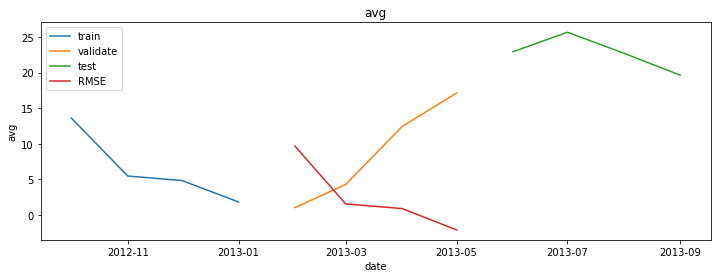

avg_unc --RMSE: 0


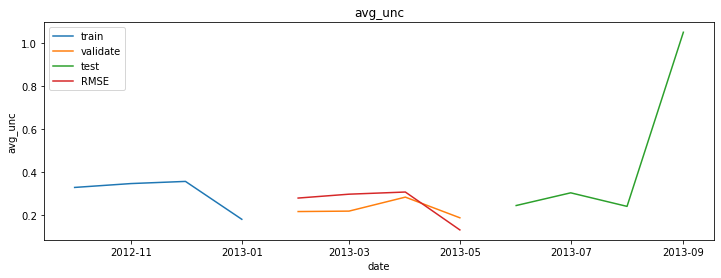

avg --RMSE: 14


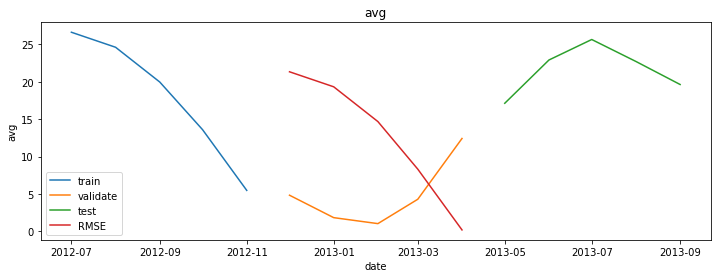

avg_unc --RMSE: 0


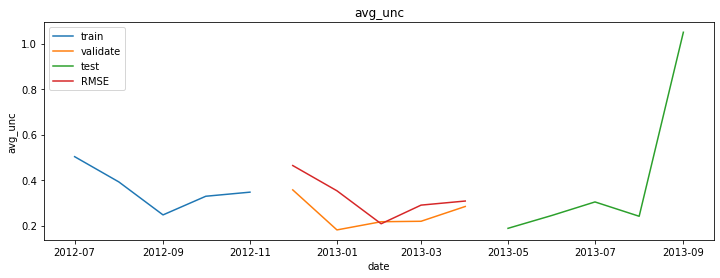

avg --RMSE: 19


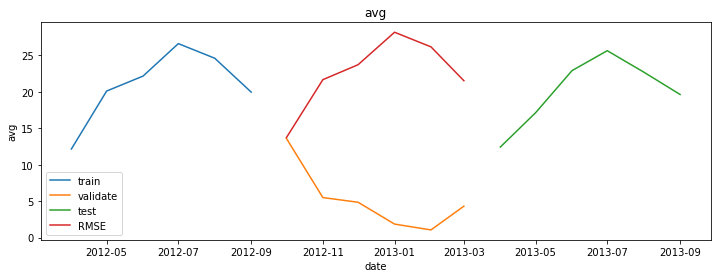

avg_unc --RMSE: 0


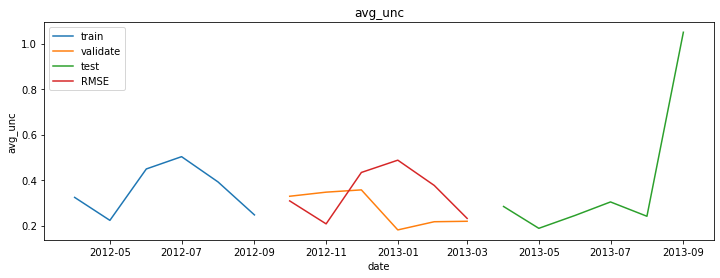

avg --RMSE: 19


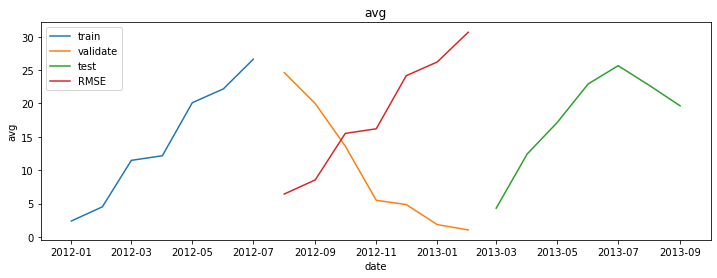

avg_unc --RMSE: 0


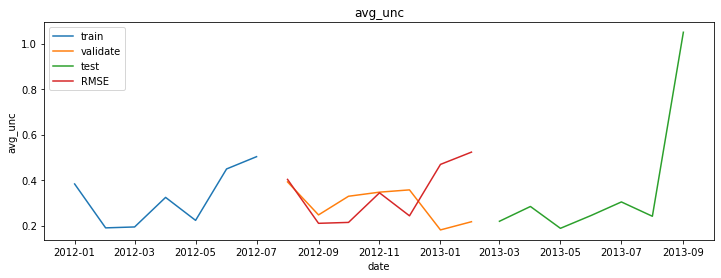

avg --RMSE: 14


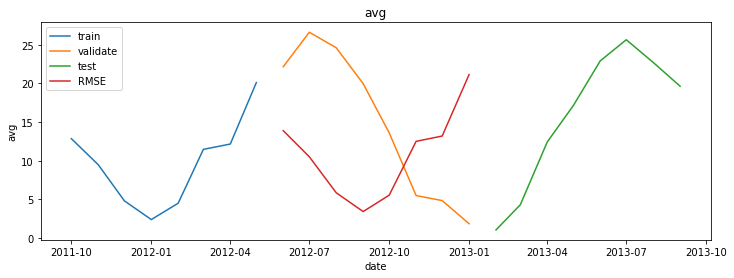

avg_unc --RMSE: 0


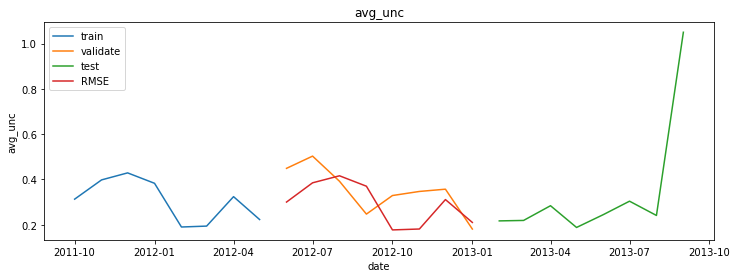

avg --RMSE: 12


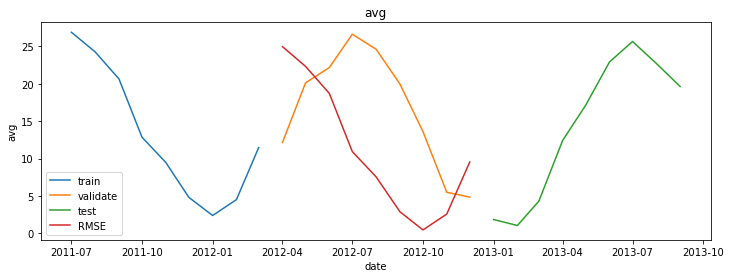

avg_unc --RMSE: 0


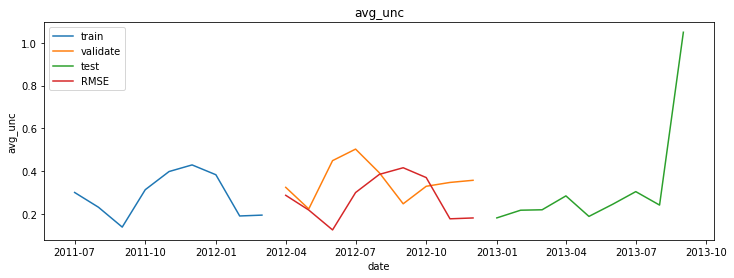

avg --RMSE: 8


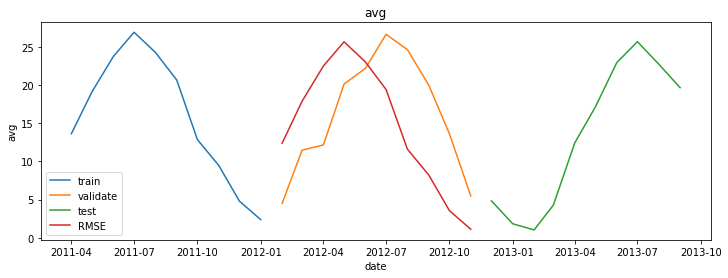

avg_unc --RMSE: 0


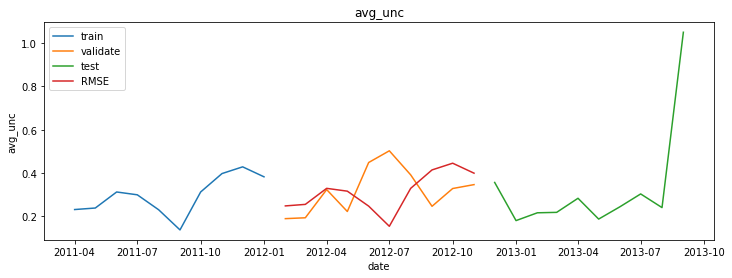

avg --RMSE: 5


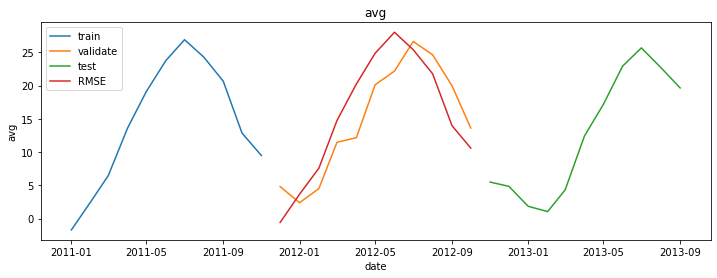

avg_unc --RMSE: 0


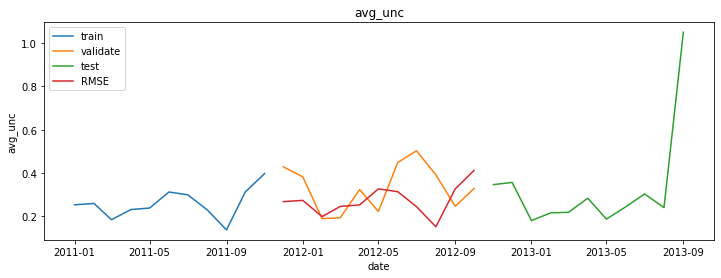

avg --RMSE: 2


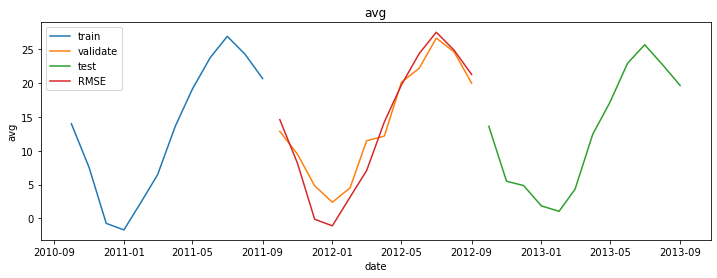

avg_unc --RMSE: 0


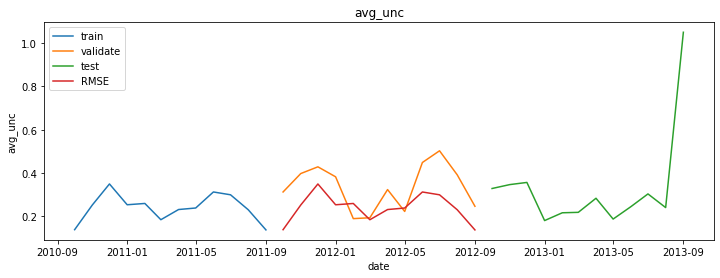

avg --RMSE: 5


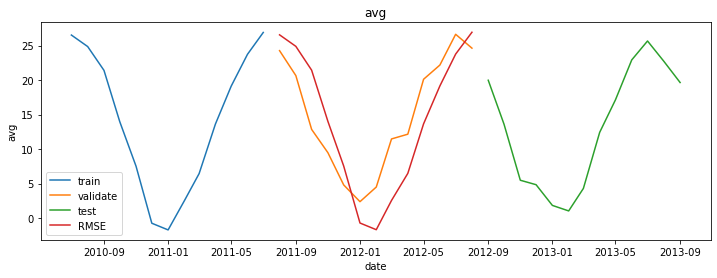

avg_unc --RMSE: 0


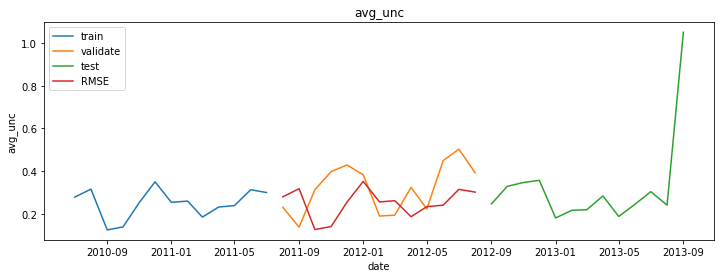

avg --RMSE: 9


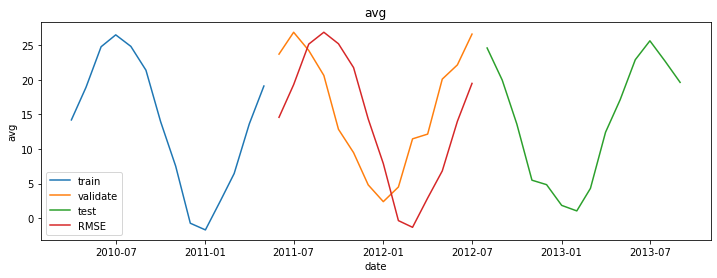

avg_unc --RMSE: 0


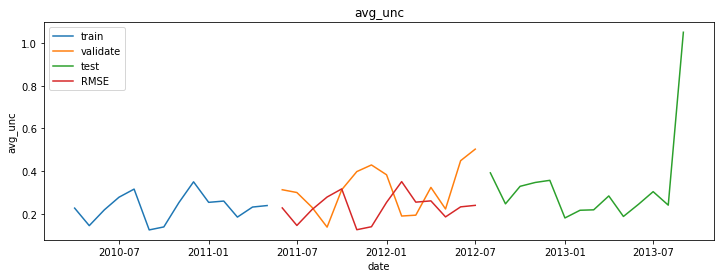

avg --RMSE: 13


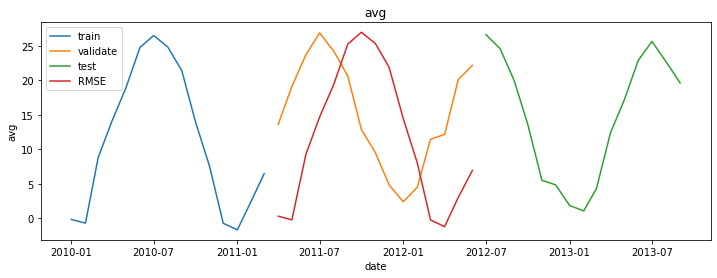

avg_unc --RMSE: 0


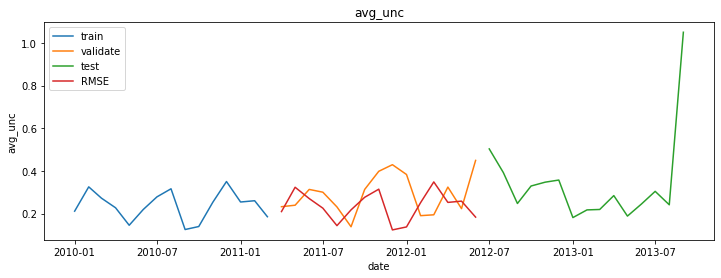

In [36]:

for n in range(2, 16):
    train = df.iloc[(n*3 * -1):(n*2*-1)]
    validate = df.iloc[(n*2*-1):(n*-1)]
    test = df.iloc[(n*-1):]
    
    yhat_df = train + train.diff().mean()

    pd.concat([yhat_df.head(1), validate.head(1)])
    yhat_df.index = validate.index

    for col in train.columns:
        plot_and_eval(col)          
        eval_df = append_eval_df(model_type=f'previous{n}_months',
                                target_var=col)

In [41]:
eval_df

,model_type,target_var,rmse
17,previous6_months,avg_unc,0.0
11,previous3_months,avg_unc,0.0
7,Holts,avg_unc,0.0
9,previous2_months,avg_unc,0.0
1,last_observed_value,avg_unc,0.0
35,previous15_months,avg_unc,0.0
13,previous4_months,avg_unc,0.0
15,previous5_months,avg_unc,0.0
19,previous7_months,avg_unc,0.0
21,previous8_months,avg_unc,0.0


The best performing model is: 28    previous12_months
Name: model_type, dtype: object


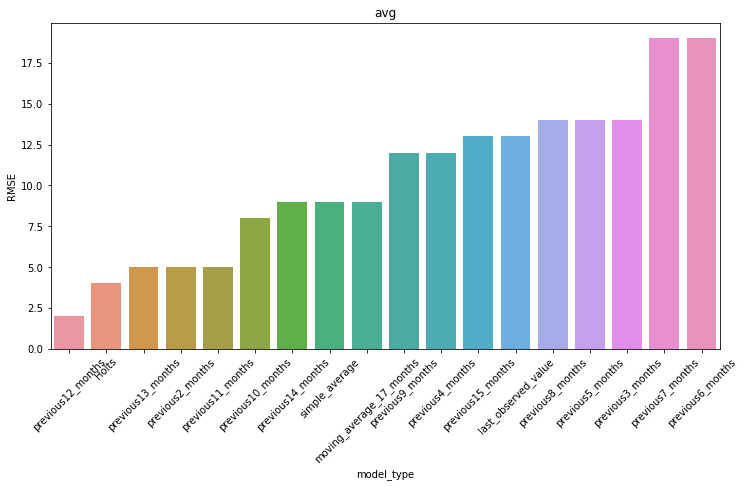

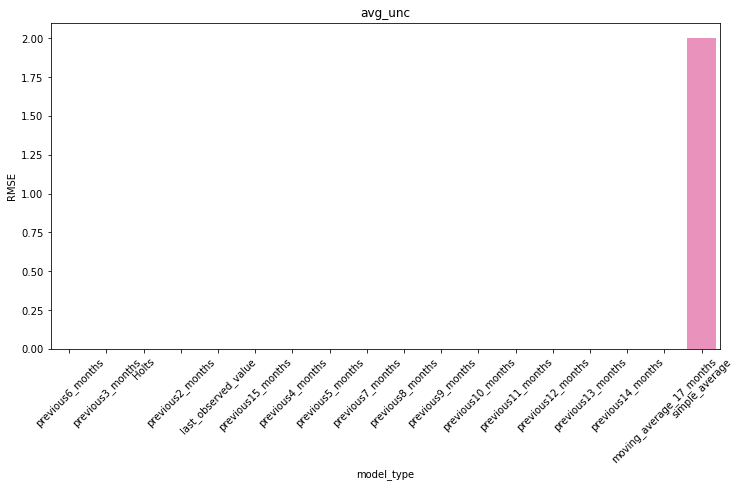

In [50]:
eval_df = eval_df.sort_values(by='rmse')
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show
    


In [53]:
print('The best performing model is:', eval_df[eval_df.target_var == 'avg'].model_type.head(1))

The best performing model is: 28    previous12_months
Name: model_type, dtype: object
